## Setting

- padding_flag: True (add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ')
- gap_flag: True (add gapped features-- 3-mer-1-gap)
- weight_flag: False (haven't figure out how to normalise non-square matrix)
- normalised_kernel: zero-mean, unit-norm
- Sum of spectrum kernel (kmer with k = 3): (K_A + K_B + K_C)/3

## Challenging: 

- regression to mean problem
- after normalisation, kernel is still not unit variance

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [41]:
# Data contains both the first round result and baseline data
#
# columns: 
# AVERAGE: average value of replicates
# Group: one of 'bps', 'uni random', 'prob random', 'bandit', 'Baseline dataset'
# RBS: 20-base RBS sequences
# RBS6: 6-length RBS seq, which the [7:13] positions
# STD: standard divation of replicates
# label: normalised label (zero mean and unit variance)
#       For the first round result, label is the (GFPOD(t0 + h) - GFPOR(t0))/h,
#                                   where t0 is the turning time point
#                                         h is the time interval (e.g. 4h)
#       For the baseline data, label is the TIR used in previous paper
#       Both of the two labels express the slope, but in different scales (calculation methods are slightly different)
#       We normalise the labels as zero mean and unit variance respectively
# variable: for first round results, denote which replication is the seq. 

Path = '../../data/firstRound_4h+Baseline.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps,AGGAGA
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.674610,0.670263,0.643113,0.662662,0.017069,0.147150,bps,AGGAGA
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps,AGGAGA
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps,AGGAGA


In [42]:
df.shape

(150, 11)

Text(0.5, 1.0, 'All label')

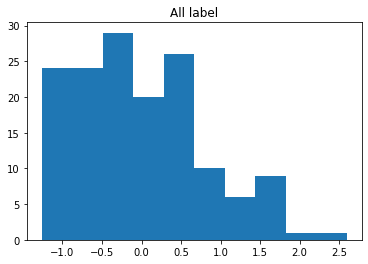

In [44]:
plt.hist(df['label'])
plt.title('All label')

(449, 8)

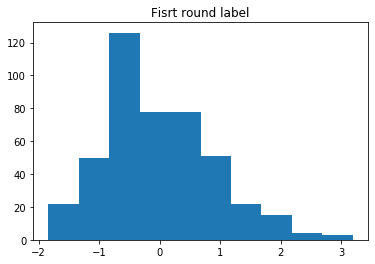

In [5]:
# extract first round result
df_FRR = df[df['Group'] != 'Baseline data']
plt.hist(df_FRR['label'])
plt.title('Fisrt round label')
df_FRR.shape

(113, 8)

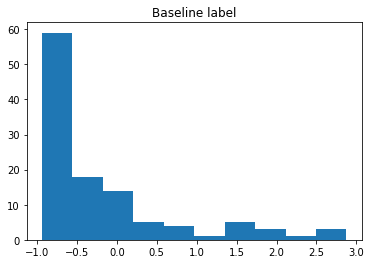

In [6]:
# extract baseline data
df_BD = df[df['Group'] == 'Baseline data']
plt.hist(df_BD['label'])
plt.title('Baseline label')
df_BD.shape

In [7]:
# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
data = np.asarray(df[['RBS', 'label']])
data_FRR = np.asarray(df_FRR[['RBS', 'label']])
data_BD = np.asarray(df_BD[['RBS', 'label']])

## Train and test on first round result

In [8]:
sorted_FRR_df = df_FRR.sort_values(['AVERAGE'])
data_sorted_FRR_df = np.asarray(sorted_FRR_df[['RBS', 'label']])

reg = Regression(GaussianProcessRegressor(kernel = Sum_Spectrum_Kernel(), alpha = 0.1, normalize_y = True), data_sorted_FRR_df, data_sorted_FRR_df,  'label')
reg.train()
sorted_FRR_df['predictions'] = reg.test_predict

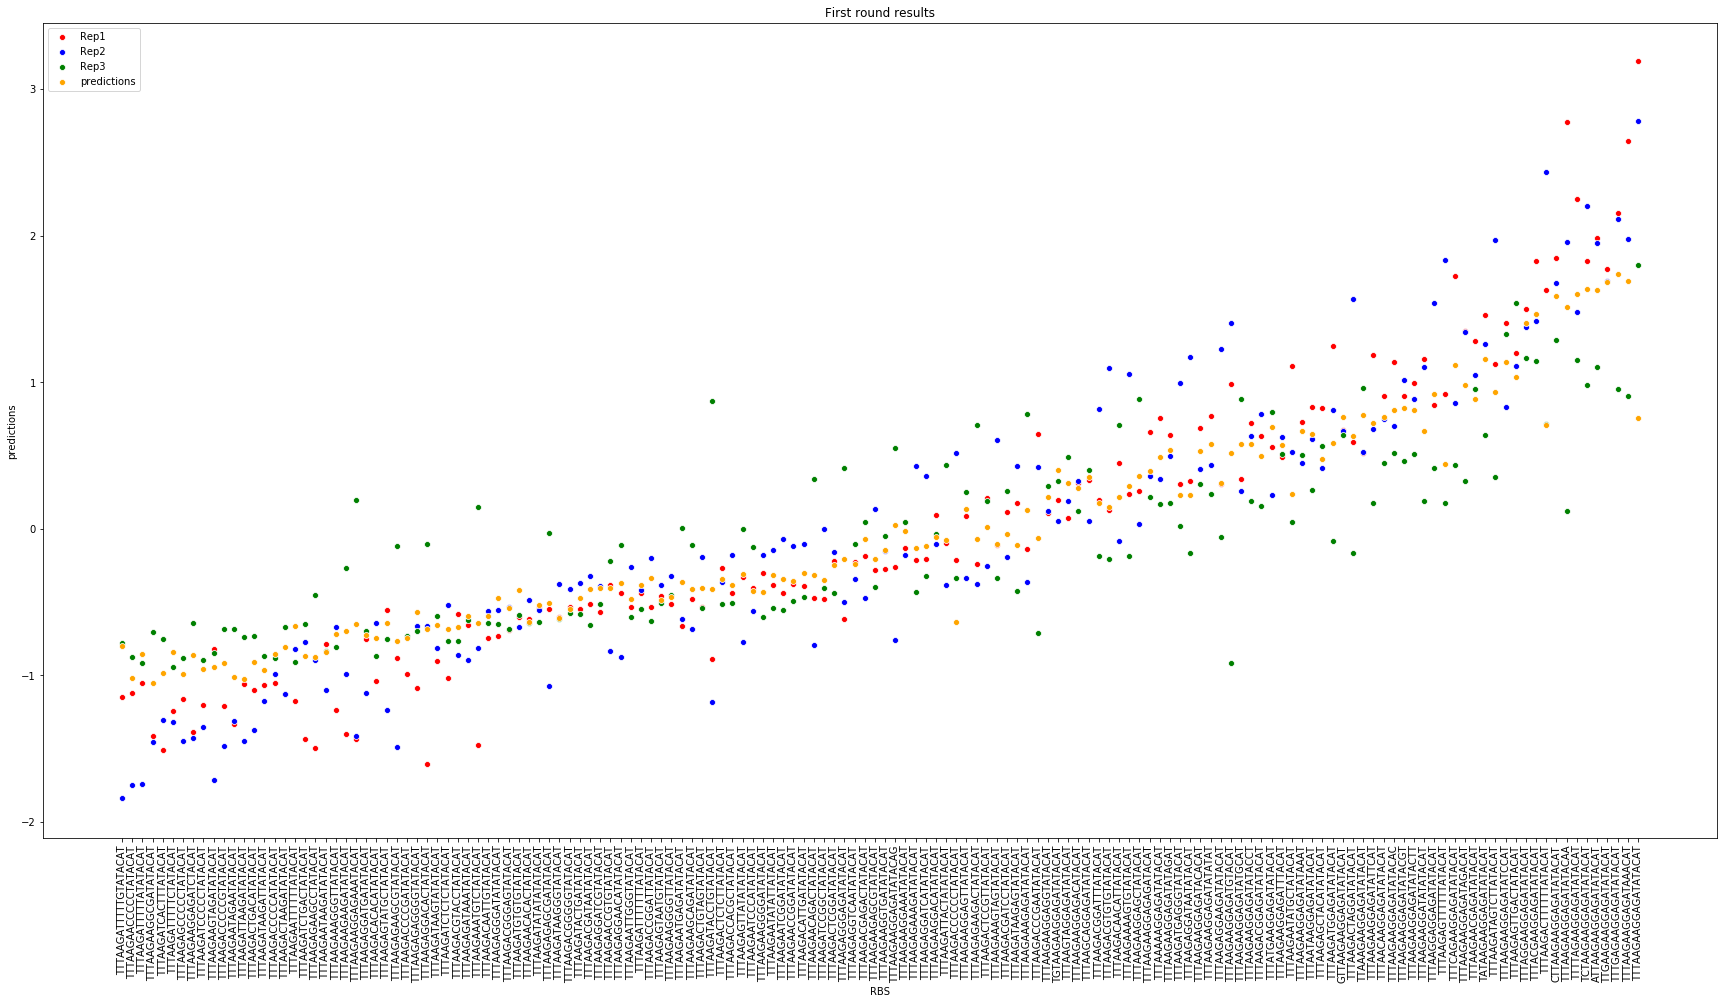

In [9]:
plt.figure(figsize = (30,15))
length = len(sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1'])
ax = sns.scatterplot(x = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1']['RBS'], y = 'label', data = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1'], color = 'red', label = 'Rep1')
sns.scatterplot(x = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep2']['RBS'], y = 'label', data = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep2'], color = 'blue', label = 'Rep2')
sns.scatterplot(x = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep3']['RBS'], y = 'label', data = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep3'], color = 'green', label = 'Rep3')
sns.scatterplot(x = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1']['RBS'], y = 'predictions', data = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1'], color = 'orange', label = 'predictions')
ax.set_title('First round results')
labels = sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1']['RBS']
ax.set_xticklabels(labels, rotation = 90)
plt.savefig('predictions.png')

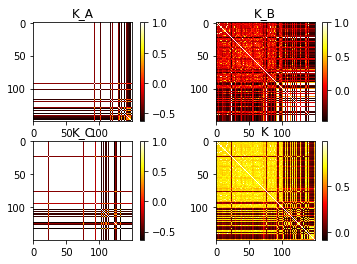

array([[ 9.90000000e-01,  6.63070457e-01,  9.43375369e-01, ...,
         1.67392690e-02,  2.45597347e-03,  5.41936273e-01],
       [ 6.63070457e-01,  9.90000000e-01,  6.62514262e-01, ...,
         1.38426580e-02, -4.40637528e-04,  5.39039662e-01],
       [ 9.43375369e-01,  6.62514262e-01,  9.90000000e-01, ...,
         1.52935956e-02,  1.01030004e-03,  5.40490600e-01],
       ...,
       [ 1.67392690e-02,  1.38426580e-02,  1.52935956e-02, ...,
         9.90000000e-01, -7.46773035e-02,  4.64802996e-01],
       [ 2.45597347e-03, -4.40637528e-04,  1.01030004e-03, ...,
        -7.46773035e-02,  9.90000000e-01,  4.50519700e-01],
       [ 5.41936273e-01,  5.39039662e-01,  5.40490600e-01, ...,
         4.64802996e-01,  4.50519700e-01,  9.90000000e-01]])

In [10]:
sorted_FRR_df_rbs = np.asarray(sorted_FRR_df[sorted_FRR_df['variable'] == 'Rep1']['RBS'])
sum_spec_kernel = Sum_Spectrum_Kernel()
sum_spec_kernel.__call__(sorted_FRR_df_rbs, sorted_FRR_df_rbs, plot_flag = True)

## Cross Validation

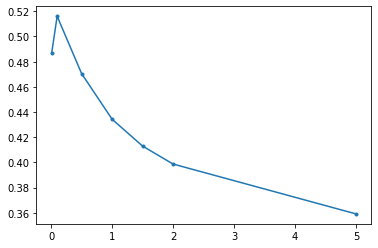

In [51]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

embedding = 'label'
kernel = Sum_Spectrum_Kernel
test_size = 0.1
random_state = 4
cv = 5
alpha_list = [0.01,0.1,0.5,1, 1.5, 2, 5]

eva_metric = r2_score

X = Rewards_env(data_FRR, embedding).embedded
y = data_FRR[:, 1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size, random_state=random_state)

cv_scores = []

for alpha in alpha_list:
    gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = alpha)
    scores = cross_val_score(gp_reg, X_train, y_train, cv = cv, scoring = make_scorer(eva_metric))
    cv_scores.append(scores.mean())
    
plt.plot(alpha_list, cv_scores, marker = '.')

0.6505856549823616


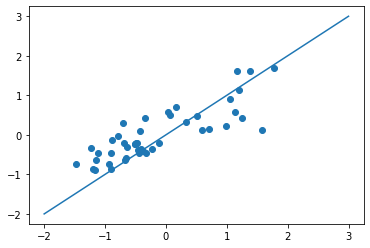

In [52]:
optimal_alpha = alpha_list[np.argmax(cv_scores)]
gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_alpha)
gp_reg.fit(X_train,y_train)
y_pred= gp_reg.predict(X_test)

print(eva_metric(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot([-2, 3], [-2,3])

In [53]:
gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_alpha)
scores = cross_val_score(gp_reg, X, y, cv = cv, scoring = make_scorer(eva_metric))
scores.mean()

0.32389153283419325

## Setting

In [14]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# regression evaluation metric, 'NRMSE' or 'r2_score'
metric = 'NRMSE'

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
#kernels = [sum_onehot_spectrum_kernel_pw]
spec_kernel = Spectrum_Kernel()
sum_spec_kernel = Sum_Spectrum_Kernel()

kernels = [sum_spec_kernel]

models = [GaussianProcessRegressor]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']

train_scores = {}
test_scores = {}
trained_reg_model_dict = {}

data_dict = {
             'all': data,
             'First round result': data_FRR,
             'Baseline data': data_BD,
             None: None
            }

alpha = 0.1 # Value added to the diagonal of the kernel matrix during fitting. 

In [15]:
def run_regression(model, data_name, kernel, embedding, alpha, data_name_test = None):
    # when data_name_test is none, the regression is run on the data_name with splitting to 80/20
    # otherwise, the regression model is trained on data_name and tested on data_name_test
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel, alpha = alpha), data_dict[data_name], data_dict[data_name_test], embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = kernel, alpha = alpha, normalize_y = True), data_dict[data_name], data_dict[data_name_test], embedding)
    
    if kernel is not str:
        kernel_name = str(spec_kernel).split('(')[0]
    else:
        kernel_name = kernel
    
    key = data_name + '_' + str(data_name_test) + '_' + regression_name[model] + '_' + kernel_name + '_' + str(embedding)
    trained_model = reg.train()
    trained_reg_model_dict[key] = trained_model
    
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag, metric = metric)
    
    
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

## Regression on individual groups

all

Model:  GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
                         kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.07941553245619248
Test NRMSE: 0.16420814554868968

Model:  GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.09101655077458834
Test NRMSE: 0.15525633468150843

Model:  GaussianProcessRegressor(alpha=0.5, copy_X_train=True,
                         kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.11187594223510026
Test NRMSE: 0.15933606

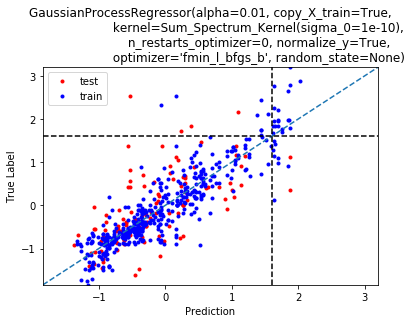

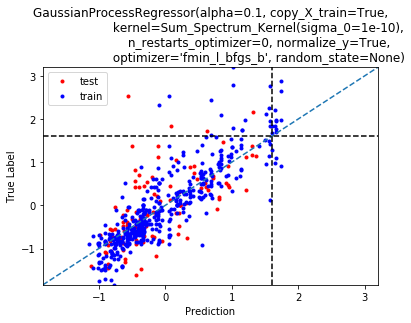

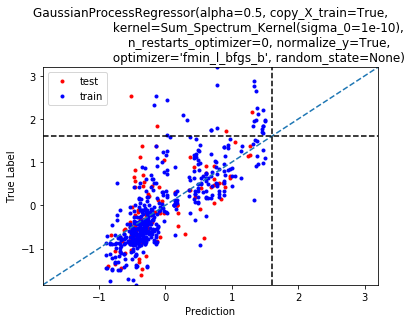

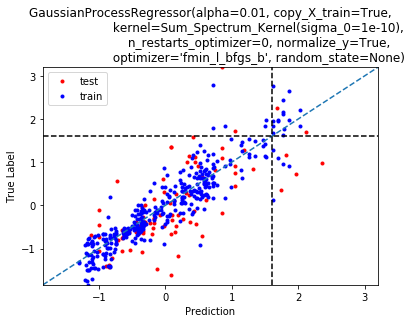

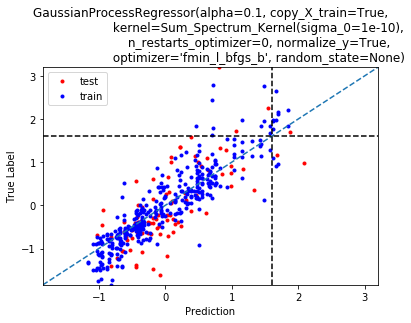

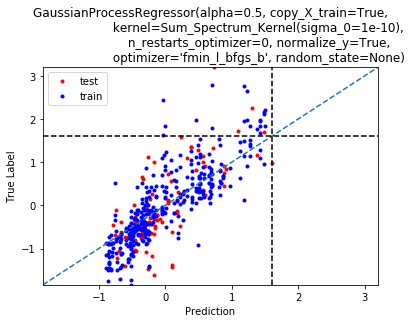

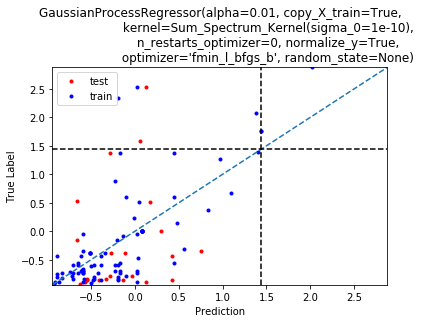

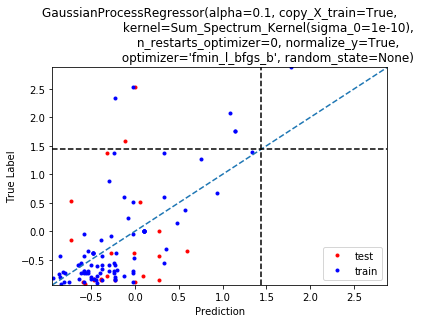

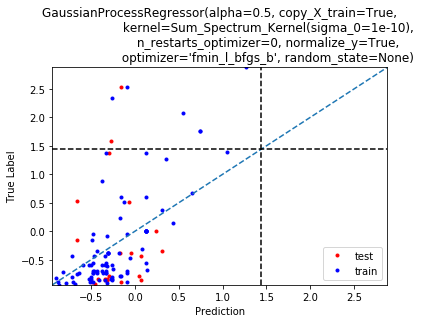

In [16]:
for data_name in data_dict.keys():
    print(data_name)
    print()
    if data_name is not None:
        for model in models:
            for kernel in kernels:
                for alpha in [0.01, 0.1, 0.5]:
                    run_regression(model, data_name, kernel, 'label', alpha)

## Regression with training on (First Round Results) FRR and testing on (Baseline) BL

Model:  GaussianProcessRegressor(alpha=1, copy_X_train=True,
                         kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.11138864356545777
Test NRMSE: 0.26182086923152287



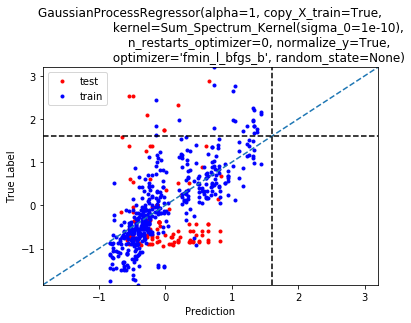

In [17]:
alpha = 1

for model in models:
    for kernel in kernels:
        run_regression(model, 'First round result', kernel, 'label', alpha, 'Baseline data')

## Regression with training on (Baseline)BL and testing on (First Round Results)FRR

Model:  GaussianProcessRegressor(alpha=1, copy_X_train=True,
                         kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.1904733614066648
Test NRMSE: 0.1728969869639035



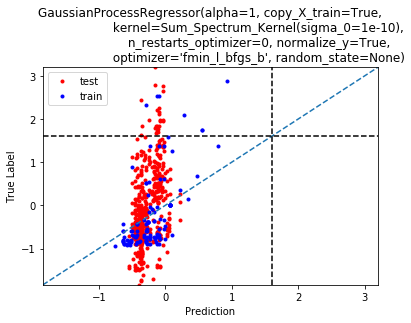

In [18]:
for model in models:
    for kernel in kernels:
        run_regression(model, 'Baseline data', kernel, 'label', alpha, 'First round result')

## Train_Rep12_Test_Rep3

The idea of this notebook is to train with Rep 1 and 2, then test with Rep 3. The label of Rep3 should inside of the confidence interval of prediction. Assuming the distribution of the replication is Gaussian,
$$p=F(\mu+n \sigma)-F(\mu-n \sigma)$$
when n = 1, p = 0.68; n = 2, p = 0.95. But since we do not have enough replications for a sequence, we evaluate the percentage using all sequences. That is, when we set n = 2, about 95% of Rep3 label of all sequences should be inside of prediction interval (well, it is not equivalent, but it's approximately correct).

In [19]:
#Path = '../../data/firstRound_4h.csv'

#df_frr = pd.read_csv(Path).dropna()
alpha_list = [0.01, 0.1, 0.5]

In [20]:
df.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,bps,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


In [21]:
def rep_cross_predict(df, alpha_list, train_on = ['Rep1', 'Rep2'], test_on = ['Rep3'], n = 2):
    # df_Rep_train = pd.melt(df_frr[['RBS'] + train_on], id_vars = ['RBS'], value_vars = train_on)
    # data_Rep_train = np.asarray(df_Rep_train[['RBS', 'value']])

    # data_Rep_test = np.asarray(df_frr[['RBS'] + test_on])
    if len(train_on) == 1:
        data_Rep_train = np.asarray(df[df['variable'] == train_on[0]][['RBS', 'label']])
    else:
        data_Rep_train = np.asarray(df[df['variable'] == train_on[0]].append(df[df['variable'] == train_on[1]])[['RBS', 'label']])
    data_Rep_test = np.asarray(df[df['variable'] == test_on[0]][['RBS', 'label']])
    
    # plot with sorted idx average true value of first round sequences
    sorted_idx = np.argsort(df[df['variable'] == test_on[0]]['AVERAGE'])

    for model in [GaussianProcessRegressor]:
        for kernel in kernels:
            print(str(kernel))
            for alpha in alpha_list:
                #run_regression(model, 'Rep12', kernel, 'label', 'Rep3')

                reg = Regression(model(kernel = kernel, alpha = alpha, normalize_y = False), data_Rep_train, data_Rep_test, 'label')
                my_model = reg.train()
                mu, std = my_model.predict(reg.X_test, return_std = True)

                plt.figure()
                plt.plot(range(len(mu)), mu[sorted_idx], label='prediction', color = 'green', alpha = 0.5)
                plt.fill_between(range(len(mu)), (mu +  n * std)[sorted_idx], (mu - n * std)[sorted_idx], label = 'confidence width', color = 'orange', alpha = 0.5)
                plt.scatter(range(len(mu)), data_Rep_test[:,1][sorted_idx], label = str(test_on), color = 'blue', s =2)
                plt.title('alpha: '+str(alpha))
                #plt.ylim([-4.5,3.5])
                plt.legend()
                plt.show()

                num_good_pred = 0
                for i,label in enumerate(data_Rep_test[:,1]):
                    if label >= mu[i] - n * std[i] and label <= mu[i] + n * std[i]:
                        num_good_pred += 1

                print('the rate of test rep labels inside of confidence width: ',float(num_good_pred)/data_Rep_test.shape[0])

                NRMSE = np.sqrt(mean_squared_error(data_Rep_test[:,1], mu))/(max(data_Rep_test[:,1]) - min(data_Rep_test[:,1]))
                print('NRMSE: ', NRMSE)

Sum_Spectrum_Kernel(sigma_0=1e-10)


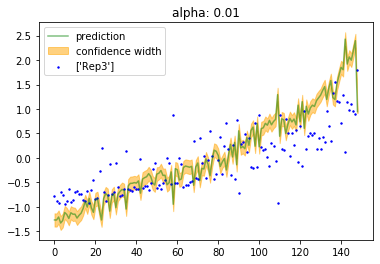

the rate of test rep labels inside of confidence width:  0.18120805369127516
NRMSE:  0.23834052019760738


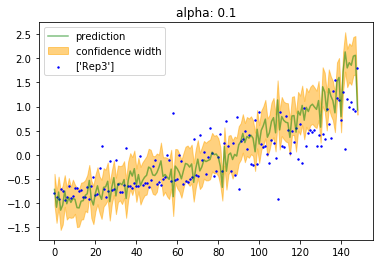

the rate of test rep labels inside of confidence width:  0.5637583892617449
NRMSE:  0.20208000045095184


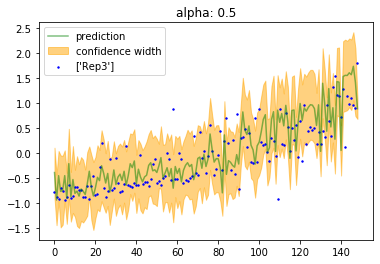

the rate of test rep labels inside of confidence width:  0.8657718120805369
NRMSE:  0.17278538811326194


In [22]:
rep_cross_predict(df, alpha_list, train_on = ['Rep1', 'Rep2'], test_on = ['Rep3'], n = 2)

Sum_Spectrum_Kernel(sigma_0=1e-10)


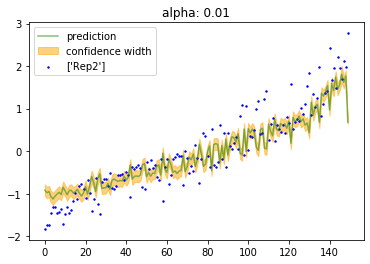

the rate of test rep labels inside of confidence width:  0.22666666666666666
NRMSE:  0.11821379399431077


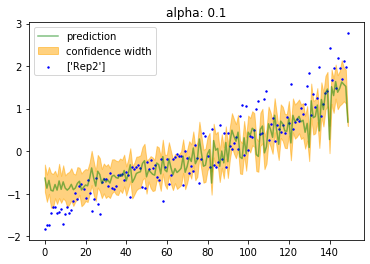

the rate of test rep labels inside of confidence width:  0.58
NRMSE:  0.13160309688743627


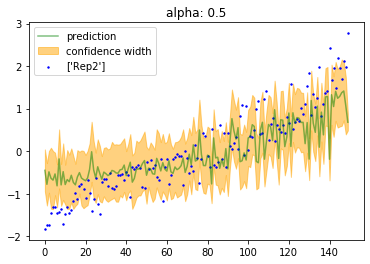

the rate of test rep labels inside of confidence width:  0.68
NRMSE:  0.15124695733883253


In [23]:
rep_cross_predict(df, alpha_list, train_on = ['Rep1', 'Rep3'], test_on = ['Rep2'], n = 2)

Sum_Spectrum_Kernel(sigma_0=1e-10)


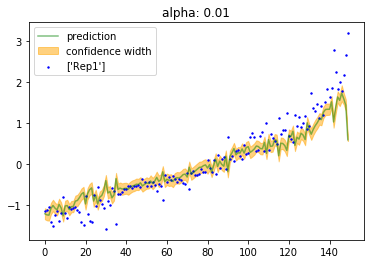

the rate of test rep labels inside of confidence width:  0.4
NRMSE:  0.09302100455293492


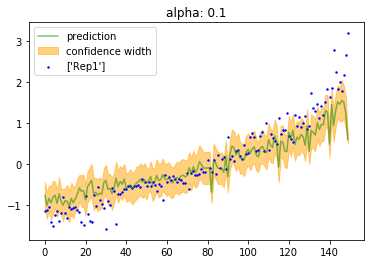

the rate of test rep labels inside of confidence width:  0.7
NRMSE:  0.10388740978132757


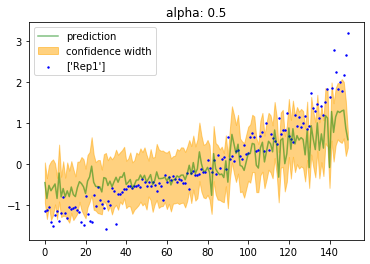

the rate of test rep labels inside of confidence width:  0.76
NRMSE:  0.12666767345160634


In [24]:
rep_cross_predict(df, alpha_list, train_on = ['Rep2', 'Rep3'], test_on = ['Rep1'], n = 2)

Sum_Spectrum_Kernel(sigma_0=1e-10)


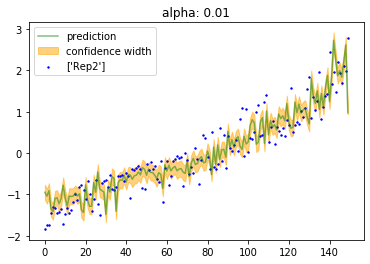

the rate of test rep labels inside of confidence width:  0.35333333333333333
NRMSE:  0.10139956727081025


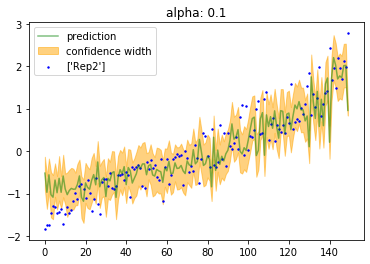

the rate of test rep labels inside of confidence width:  0.7066666666666667
NRMSE:  0.12305186073218798


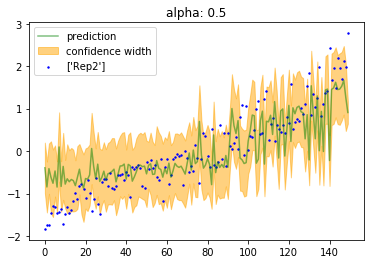

the rate of test rep labels inside of confidence width:  0.7933333333333333
NRMSE:  0.15090792663882208


In [25]:
rep_cross_predict(df, alpha_list, train_on = ['Rep1'], test_on = ['Rep2'], n = 2)

Sum_Spectrum_Kernel(sigma_0=1e-10)


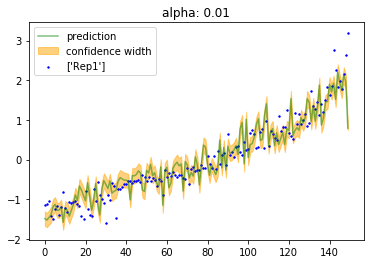

the rate of test rep labels inside of confidence width:  0.4
NRMSE:  0.08863574225212627


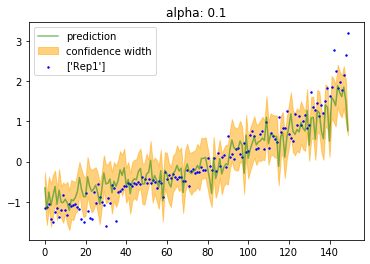

the rate of test rep labels inside of confidence width:  0.7733333333333333
NRMSE:  0.09604922581927225


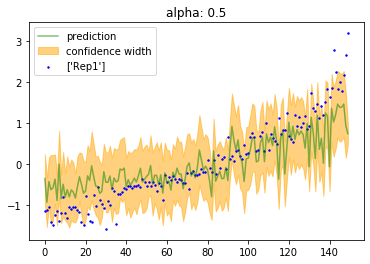

the rate of test rep labels inside of confidence width:  0.8133333333333334
NRMSE:  0.12593389368250935


In [26]:
rep_cross_predict(df, alpha_list, train_on = ['Rep2'], test_on = ['Rep1'], n = 2)

### which $\alpha$ value is good?

As $\alpha$ increases, the confidence interval is getting wider but the NRMSE is getting larger. Surprisingly, when $\alpha$ is extremely small (1e-10), the trend does not hold. When we look at the top arms (arms with top average true labels), small $\alpha$ gives a better prediction. When $\alpha > 0.1$, the predictions of top arms decrease. So the default value (1e-10) of $\alpha$ seems to be a good choice. 

## Similar arms have similar confidence interval?

Theoritically, if two arms are neighbouring, their confidence interval should be similar if they are both observed or unobserved. And if one is unobserved, then it's confidence interval should be bigger than the one observed. 

The following code cannot extactly express the idea though. Since it shows whether the similarity of arms with similar confidence interval. However, how can we sort kernel matrix?

In [27]:
model = GaussianProcessRegressor
alpha = 0.5
n = 2
np.random.shuffle(data_FRR)
test_data = data_FRR
num_data = test_data.shape[0]

In [28]:
reg = Regression(model(kernel = kernel, alpha = alpha, normalize_y = True), test_data[: int(0.8 * num_data), :], test_data[int(0.8 * num_data):, :], embedding_method = 'label')
my_model = reg.train()
mu_train, std_train = my_model.predict(reg.X_train, return_std = True)
mu_test, std_test = my_model.predict(reg.X_test, return_std = True)


In [29]:
std = list(std_train) + list(std_test)

confidence_interval = n * np.asarray(std) * 2
sorted_idx = np.asarray(sorted(range(len(confidence_interval)), key=lambda k: (confidence_interval)[k]))
sorted_sorted_idx = np.argsort(sorted_idx)

observed_ci = confidence_interval[np.asarray(sorted_idx) <= int(0.8 * num_data)]
unobserved_ci = confidence_interval[np.asarray(sorted_idx) > int(0.8 * num_data)]

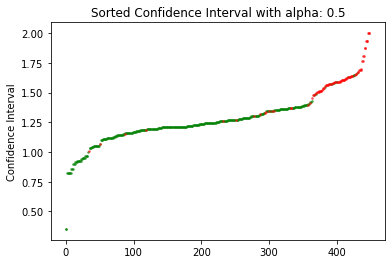

In [30]:
plt.figure()
plt.scatter(sorted_sorted_idx[np.asarray(sorted_idx) <= int(0.8 * num_data)], observed_ci, color = 'green', s = 3, alpha = 0.5)
plt.scatter(sorted_sorted_idx[np.asarray(sorted_idx) > int(0.8 * num_data)], unobserved_ci, color = 'red', s = 3, alpha = 0.5)
#plt.fill_between(range(len(mu)), mu +  n * std, mu - n * std, label = 'confidence width', color = 'orange', alpha = 0.5)
#plt.scatter(range(len(mu)), data_Rep3[:,1], label = 'Rep3 label', color = 'blue', s =2)
plt.title('Sorted Confidence Interval with alpha: '+str(alpha))
plt.ylabel('Confidence Interval')
plt.show()

In [31]:
kernel_matrix = sum_spec_kernel.__call__(test_data[sorted_idx, 0], test_data[sorted_idx, 0])

Text(0.5, 1.0, 'Kernel matrix for sorted confidence interval')

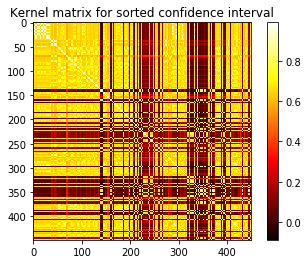

In [32]:
plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
plt.colorbar()
plt.title('Kernel matrix for sorted confidence interval')

## Compare

Text(0.5, 1.0, 'Test Scores')

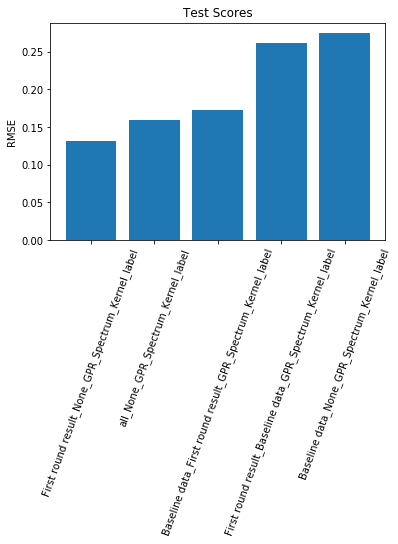

In [33]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

## Save into file

In [34]:
import pickle

with open('trained_reg_model.pickle', 'wb') as handle:
    pickle.dump(trained_reg_model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)